<h2> Necessary Imports </h2>

In [1]:
!pip install fastmri -q
!pip install einops -q
!pip install wandb -q

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
from einops import rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.checkpoint as checkpoint
from torch.utils.data import Dataset, DataLoader
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [3]:
import math
import fastmri
from fastmri.data import transforms
from fastmri import fft2c, ifft2c, rss_complex, complex_abs
from typing import Dict, Optional, Sequence, Tuple, List, Union, NamedTuple, Any, Callable

In [4]:
import random
import xml.etree.ElementTree as etree
import matplotlib.pyplot as plt
from typing import TextIO
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

<h2> Data Directory </h2>

<h4> Single Coil </h4>

In [5]:
# df1 = pd.read_csv('/kaggle/input/fastmri-trained-models/train_knee_single_coil.csv')
# df2 = pd.read_csv('/kaggle/input/fastmri-trained-models/validation_knee_single_coil.csv')

# acq = ['CORPD_FBK', 'CORPDS_FBK']
# filt1 = df1['acquisition'] == acq[0]
# filt2 = df2['acquisition'] == acq[0]
# train_file = df1[filt1]['file_name'].values
# val_file = df2[filt2]['file_name'].values
# print(len(train_file), len(val_file))

# train_file, val_file = [], []
# train_file.extend([os.path.join(path1, f) for f in os.listdir(path1)])
# train_file.extend([os.path.join(path2, f) for f in os.listdir(path2)])
# val_file.extend([os.path.join(path3, f) for f in os.listdir(path3)])

<h4> Multi-coil </h4>

In [6]:
path4 = '/kaggle/input/brain-single-coil-val-batch-0'
path5 = '/kaggle/input/m4raw-kspace/multicoil_train'
path6 = '/kaggle/input/multicoil-knee'

In [7]:
# multicoil = []
# multicoil.extend([os.path.join(path4, f) for f in os.listdir(path4)])
# multicoil.extend([os.path.join(path5, f) for f in os.listdir(path5)])
# multicoil.extend([os.path.join(path6, f) for f in os.listdir(path6)])
# train_file, val_file = train_test_split(multicoil, test_size=0.2, random_state=42)

In [8]:
# acq = ['AXFLAIR', 'AXT1', 'AXT2']
acq = ['CORPD_FBK', 'CORPDFS_FBK']

# df1 = pd.read_csv('/kaggle/input/fastmri-trained-models/train_M4Raw.csv')
# df2 = pd.read_csv('/kaggle/input/fastmri-trained-models/val_M4Raw.csv')

df1 = pd.read_csv('/kaggle/input/fastmri-trained-models/train_knee_multi_coil.csv')
df2 = pd.read_csv('/kaggle/input/fastmri-trained-models/validation_knee_multi_coil.csv')

filt1 = df1['acquisition'] == acq[0]
filt2 = df2['acquisition'] == acq[0]

train_file = df1[filt1]['file_name'].values
val_file = df2[filt2]['file_name'].values
print(len(train_file), len(val_file))

158 29


<h2> Utils </h2>

In [9]:
class Args:
    def __init__(self, args_dict):
        for key, value in args_dict.items():
            setattr(self, key, value)

In [10]:
class MaskFunc:
    def __init__(
        self,
        center_fractions: Sequence[float],
        accelerations: Sequence[int],
        allow_any_combination: bool = False,
        seed: Optional[int] = None,
    ):
        if len(center_fractions) != len(accelerations) and not allow_any_combination:
            raise ValueError(
                "Number of center fractions should match number of accelerations "
                "if allow_any_combination is False."
            )

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.allow_any_combination = allow_any_combination
        self.rng = np.random.RandomState(seed)

    def __call__(
        self,
        shape: Sequence[int],
        offset: Optional[int] = None,
        seed: Optional[Union[int, Tuple[int, ...]]] = None,
    ) -> Tuple[torch.Tensor, int]:
        
        if len(shape) < 3:
            raise ValueError("Shape should have 3 or more dimensions")

        with temp_seed(self.rng, seed):
            center_mask, accel_mask, num_low_frequencies = self.sample_mask(
                shape, offset
            )

        # combine masks together
        return torch.max(center_mask, accel_mask), num_low_frequencies

    def sample_mask(
        self,
        shape: Sequence[int],
        offset: Optional[int],
    ) -> Tuple[torch.Tensor, torch.Tensor, int]:
        
        num_cols = shape[-2]
        center_fraction, acceleration = self.choose_acceleration()
        num_low_frequencies = round(num_cols * center_fraction)
        center_mask = self.reshape_mask(
            self.calculate_center_mask(shape, num_low_frequencies), shape
        )
        acceleration_mask = self.reshape_mask(
            self.calculate_acceleration_mask(
                num_cols, acceleration, offset, num_low_frequencies
            ),
            shape,
        )

        return center_mask, acceleration_mask, num_low_frequencies

    def reshape_mask(self, mask: np.ndarray, shape: Sequence[int]) -> torch.Tensor:
        """Reshape mask to desired output shape."""
        num_cols = shape[-2]
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols

        return torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

    def calculate_acceleration_mask(
        self,
        num_cols: int,
        acceleration: int,
        offset: Optional[int],
        num_low_frequencies: int,
    ) -> np.ndarray:
        
        raise NotImplementedError

    def calculate_center_mask(
        self, shape: Sequence[int], num_low_freqs: int
    ) -> np.ndarray:
        
        num_cols = shape[-2]
        mask = np.zeros(num_cols, dtype=np.float32)
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad : pad + num_low_freqs] = 1
        assert mask.sum() == num_low_freqs

        return mask

    def choose_acceleration(self):
        """Choose acceleration based on class parameters."""
        if self.allow_any_combination:
            return self.rng.choice(self.center_fractions), self.rng.choice(
                self.accelerations
            )
        else:
            choice = self.rng.randint(len(self.center_fractions))
            return self.center_fractions[choice], self.accelerations[choice]


class RandomMaskFunc(MaskFunc):

    def calculate_acceleration_mask(
        self,
        num_cols: int,
        acceleration: int,
        offset: Optional[int],
        num_low_frequencies: int,
    ) -> np.ndarray:
        prob = (num_cols / acceleration - num_low_frequencies) / (
            num_cols - num_low_frequencies
        )

        return self.rng.uniform(size=num_cols) < prob


class EquiSpacedMaskFunc(MaskFunc):

    def calculate_acceleration_mask(
        self,
        num_cols: int,
        acceleration: int,
        offset: Optional[int],
        num_low_frequencies: int,
    ) -> np.ndarray:
        if offset is None:
            offset = self.rng.randint(0, high=round(acceleration))

        mask = np.zeros(num_cols, dtype=np.float32)
        mask[offset::acceleration] = 1

        return mask

class EquispacedMaskFractionFunc(MaskFunc):
    def calculate_acceleration_mask(
        self,
        num_cols: int,
        acceleration: int,
        offset: Optional[int],
        num_low_frequencies: int,
    ) -> np.ndarray:
        # determine acceleration rate by adjusting for the number of low frequencies
        adjusted_accel = (acceleration * (num_low_frequencies - num_cols)) / (
            num_low_frequencies * acceleration - num_cols
        )
        if offset is None:
            offset = self.rng.randint(0, high=round(adjusted_accel))

        mask = np.zeros(num_cols)
        accel_samples = np.arange(offset, num_cols - 1, adjusted_accel)
        accel_samples = np.around(accel_samples).astype(np.uint)
        mask[accel_samples] = 1.0
        return mask

In [11]:
import contextlib
@contextlib.contextmanager
def temp_seed(rng: np.random.RandomState, seed: Optional[Union[int, Tuple[int, ...]]]):
    """A context manager for temporarily adjusting the random seed."""
    if seed is None:
        try:
            yield
        finally:
            pass
    else:
        state = rng.get_state()
        rng.seed(seed)
        try:
            yield
        finally:
            rng.set_state(state)

In [12]:
def create_mask_for_mask_type(
    mask_type_str: str,
    center_fractions: Sequence[float],
    accelerations: Sequence[int],
) -> MaskFunc:
    """
    Creates a mask of the specified type.

    Args:
        center_fractions: What fraction of the center of k-space to include.
        accelerations: What accelerations to apply.

    Returns:
        A mask func for the target mask type.
    """
    if mask_type_str == "random":
        return RandomMaskFunc(center_fractions, accelerations)
    elif mask_type_str == "equispaced":
        return EquiSpacedMaskFunc(center_fractions, accelerations)
    elif mask_type_str == "equispaced_fraction":
        return EquispacedMaskFractionFunc(center_fractions, accelerations)
    elif mask_type_str == "magic":
        return MagicMaskFunc(center_fractions, accelerations)
    elif mask_type_str == "magic_fraction":
        return MagicMaskFractionFunc(center_fractions, accelerations)
    else:
        raise ValueError(f"{mask_type_str} not supported")


In [13]:
def to_tensor(data: np.ndarray) -> torch.Tensor:
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)

def tensor_to_complex_np(data: torch.Tensor) -> np.ndarray:
    return torch.view_as_complex(data).numpy()

def apply_mask(
    data: torch.Tensor,
    mask_func: MaskFunc,
    offset: Optional[int] = None,
    seed: Optional[Union[int, Tuple[int, ...]]] = None,
    padding: Optional[Sequence[int]] = None,
) -> Tuple[torch.Tensor, torch.Tensor, int]:
    shape = (1,) * len(data.shape[:-3]) + tuple(data.shape[-3:])
    mask, num_low_frequencies = mask_func(shape, offset, seed)
    if padding is not None:
        mask[..., : padding[0], :] = 0
        mask[..., padding[1] :, :] = 0  # padding value inclusive on right of zeros

    masked_data = data * mask + 0.0  # the + 0.0 removes the sign of the zeros

    return masked_data, mask, num_low_frequencies

In [14]:
def mask_center(x: torch.Tensor, mask_from: int, mask_to: int) -> torch.Tensor:
    mask = torch.zeros_like(x)
    mask[:, :, :, mask_from:mask_to] = x[:, :, :, mask_from:mask_to]

    return mask


def batched_mask_center(
    x: torch.Tensor, mask_from: torch.Tensor, mask_to: torch.Tensor
) -> torch.Tensor:
    if not mask_from.shape == mask_to.shape:
        raise ValueError("mask_from and mask_to must match shapes.")
    if not mask_from.ndim == 1:
        raise ValueError("mask_from and mask_to must have 1 dimension.")
    if not mask_from.shape[0] == 1:
        if (not x.shape[0] == mask_from.shape[0]) or (
            not x.shape[0] == mask_to.shape[0]
        ):
            raise ValueError("mask_from and mask_to must have batch_size length.")

    if mask_from.shape[0] == 1:
        mask = mask_center(x, int(mask_from), int(mask_to))
    else:
        mask = torch.zeros_like(x)
        for i, (start, end) in enumerate(zip(mask_from, mask_to)):
            mask[i, :, :, start:end] = x[i, :, :, start:end]

    return mask


def center_crop(data: torch.Tensor, shape: Tuple[int, int]) -> torch.Tensor:
    if not (0 < shape[0] <= data.shape[-2] and 0 < shape[1] <= data.shape[-1]):
        raise ValueError("Invalid shapes.")

    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]

    return data[..., w_from:w_to, h_from:h_to]


def complex_center_crop(data: torch.Tensor, shape: Tuple[int, int]) -> torch.Tensor:
    if not (0 < shape[0] <= data.shape[-3] and 0 < shape[1] <= data.shape[-2]):
        raise ValueError("Invalid shapes.")

    w_from = (data.shape[-3] - shape[0]) // 2
    h_from = (data.shape[-2] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]

    return data[..., w_from:w_to, h_from:h_to, :]


def center_crop_to_smallest(
    x: torch.Tensor, y: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    smallest_width = min(x.shape[-1], y.shape[-1])
    smallest_height = min(x.shape[-2], y.shape[-2])
    x = center_crop(x, (smallest_height, smallest_width))
    y = center_crop(y, (smallest_height, smallest_width))

    return x, y


def normalize(
    data: torch.Tensor,
    mean: Union[float, torch.Tensor],
    stddev: Union[float, torch.Tensor],
    eps: Union[float, torch.Tensor] = 0.0,
) -> torch.Tensor:
    return (data - mean) / (stddev + eps)


def normalize_instance(
    data: torch.Tensor, eps: Union[float, torch.Tensor] = 0.0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    mean = data.mean()
    std = data.std()

    return normalize(data, mean, std, eps), mean, std

In [15]:
def et_query(root: etree.Element, qlist: Sequence[str], namespace: str = "http://www.ismrm.org/ISMRMRD"):
    s = "."
    prefix = "ismrmrd_namespace"
    ns = {prefix: namespace}
    for el in qlist:
        s = s + f"//{prefix}:{el}"
    value = root.find(s, ns)
    if value is None:
        raise RuntimeError("Element not found")
    return str(value.text)


class FastMRIRawDataSample(NamedTuple):
    fname: str
    slice_ind: int
    metadata: Dict[str, Any]

def resize_image(image_tensor):
    image_tensor = transforms.ToPILImage()(image_tensor).resize((img_width, img_height), resample=Image.BICUBIC)
    image_tensor = transforms.ToTensor()(image_tensor)
    return image_tensor

def Raw_sample_filter(raw_sample):
    return True

class VarNetSample(NamedTuple):
    """
    A sample of masked k-space for variational network reconstruction.

    Args:
        masked_kspace: k-space after applying sampling mask.
        mask: The applied sampling mask.
        num_low_frequencies: The number of samples for the densely-sampled
            center.
        target: The target image (if applicable).
        fname: File name.
        slice_num: The slice index.
        max_value: Maximum image value.
        crop_size: The size to crop the final image.
    """

    masked_kspace: torch.Tensor
    mask: torch.Tensor
#     num_low_frequencies: Optional[int]
    target: torch.Tensor
    fname: str
    slice_num: int
    max_value: float
    crop_size: Tuple[int, int]

<h2> Data Preprocessing </h2>

In [16]:
class DataTransform:
    """
    Data Transformer for training HUMUS-Net model.
    """

    def __init__(self,
                 uniform_train_resolution: Union[List[int], Tuple[int]],
                 mask_func: Optional[MaskFunc] = None,
                 use_seed: bool = True,
):
    
        self.mask_func = mask_func
        self.use_seed = use_seed
        self.uniform_train_resolution = uniform_train_resolution

    def _crop_if_needed(self, image):
        w_from = h_from = 0

        if self.uniform_train_resolution[0] < image.shape[-3]:
            w_from = (image.shape[-3] - self.uniform_train_resolution[0]) // 2
            w_to = w_from + self.uniform_train_resolution[0]
        else:
            w_to = image.shape[-3]

        if self.uniform_train_resolution[1] < image.shape[-2]:
            h_from = (image.shape[-2] - self.uniform_train_resolution[1]) // 2
            h_to = h_from + self.uniform_train_resolution[1]
        else:
            h_to = image.shape[-2]

        return image[..., w_from:w_to, h_from:h_to, :]

    def _pad_if_needed(self, image):
        pad_w = self.uniform_train_resolution[0] - image.shape[-3]
        pad_h = self.uniform_train_resolution[1] - image.shape[-2]

        if pad_w > 0:
            pad_w_left = pad_w // 2
            pad_w_right = pad_w - pad_w_left
        else:
            pad_w_left = pad_w_right = 0

        if pad_h > 0:
            pad_h_left = pad_h // 2
            pad_h_right = pad_h - pad_h_left
        else:
            pad_h_left = pad_h_right = 0

        return torch.nn.functional.pad(image.permute(0, 3, 1, 2), (pad_h_left, pad_h_right, pad_w_left, pad_w_right), 'reflect').permute(0, 2, 3, 1)

    def _to_uniform_size(self, kspace):
        image = ifft2c(kspace)
        image = self._crop_if_needed(image)
        image = self._pad_if_needed(image)
        kspace = fft2c(image)
        return kspace

    def __call__(
        self,
        kspace: np.ndarray,
        mask: np.ndarray,
        target: np.ndarray,
        attrs: Dict,
        fname: str,
        slice_num: int,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, str, int, float, torch.Tensor]:
        """
        Args:
            kspace: Input k-space of shape (num_coils, rows, cols) for
                multi-coil data.
            mask: Mask from the test dataset.
            target: Target image.
            attrs: Acquisition related information stored in the HDF5 object.
            fname: File name.
            slice_num: Serial number of the slice.
        Returns:
            tuple containing:
                masked_kspace: k-space after applying sampling mask.
                mask: The applied sampling mask
                target: The target image (if applicable).
                fname: File name.
                slice_num: The slice index.
                max_value: Maximum image value.
                crop_size: The size to crop the final image.
        """
        is_testing = (target is None)

        kspace = kspace.astype(np.complex64)

        # Add singleton channel dimension if singlecoil
        if len(kspace.shape) == 2:
            kspace = np.expand_dims(kspace, axis=0)
        # Concatenate slices along channel dim if multi-slice
        elif len(kspace.shape) == 4:
            H, W = kspace.shape[-2:]
            kspace = np.reshape(kspace, (-1, H, W))
        assert len(kspace.shape) == 3

        if not is_testing:
            target = target.astype(np.float32)
            target = to_tensor(target)
#             target, *_ = transforms.normalize_instance(target, eps=1e-11)
#             target = target.clamp(-1, 1)
            max_value = attrs["max"].astype(np.float32)
        else:
            target = torch.tensor(0)
            max_value = 0.0

        kspace = to_tensor(kspace)

        if not is_testing:
            kspace = self._to_uniform_size(kspace)
        else:
            # Only crop image height
            if self.uniform_train_resolution[0] < kspace.shape[-3]:
                image = ifft2c(kspace)
                h_from = (image.shape[-3] - self.uniform_train_resolution[0]) // 2
                h_to = h_from + self.uniform_train_resolution[0]
                image = image[..., h_from:h_to, :, :]
                kspace = fft2c(image)

        seed = None if not self.use_seed else tuple(map(ord, fname))
        acq_start = attrs["padding_left"]
        acq_end = attrs["padding_right"]

        if not is_testing:
            crop_size = torch.tensor([target.shape[0], target.shape[1]])
        else:
            crop_size = (attrs["recon_size"][0], attrs["recon_size"][1])

        if self.mask_func:
            masked_kspace, mask, _ = apply_mask(
                kspace, self.mask_func, seed = seed, padding=(acq_start, acq_end)
            )
        else:
            masked_kspace = kspace
            shape = np.array(kspace.shape)
            num_cols = shape[-2]
            shape[:-3] = 1
            mask_shape = [1] * len(shape)
            mask_shape[-2] = num_cols
            mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))
            mask = mask.reshape(*mask_shape)
            mask[:, :, :acq_start] = 0
            mask[:, :, acq_end:] = 0

        return (
            masked_kspace,
            mask.byte(),
            target,
            fname,
            slice_num,
            max_value,
            crop_size,
        )

<h2> Data Loader </h2>

In [17]:
class Mri_Data(Dataset):
    def __init__(self, Files, transform, challenge):
        self.file = Files
        self.transform = transform
        self.challenge = challenge
        self.start = 0
        self.end = None

    def _retrive_metadata(self, hf: TextIO):
        et_root = etree.fromstring(hf["ismrmrd_header"][()])

        enc = ["encoding", "encodedSpace", "matrixSize"]
        enc_size = (
            int(et_query(et_root, enc + ["x"])),
            int(et_query(et_root, enc + ["y"])),
            int(et_query(et_root, enc + ["z"])),
        )
        rec = ["encoding", "reconSpace", "matrixSize"]
        recon_size = (
            int(et_query(et_root, rec + ["x"])),
            int(et_query(et_root, rec + ["y"])),
            int(et_query(et_root, rec + ["z"])),
        )

        lims = ["encoding", "encodingLimits", "kspace_encoding_step_1"]
        enc_limits_center = int(et_query(et_root, lims + ["center"]))
        enc_limits_max = int(et_query(et_root, lims + ["maximum"])) + 1

        padding_left = enc_size[1] // 2 - enc_limits_center
        padding_right = padding_left + enc_limits_max

        num_slices = hf["kspace"].shape[0]

        metadata = {
            "padding_left": padding_left,
            "padding_right": padding_right,
            "encoding_size": enc_size,
            "recon_size": recon_size,
        }
        return metadata


    def __len__(self):
        return len(self.file)


    def __getitem__(self, index):
        Masked_kspace, Mask, Target, Slice_num, Max_value, Crop_size = [], [], [], [], [], []
        with h5py.File(self.file[index], 'r') as hf:

            kspace = hf['kspace']
            if self.challenge == 'multicoil':
                rec_esc = hf['reconstruction_rss']
            else:
                rec_esc = hf['reconstruction_rss']

            attr = dict(hf.attrs)
            attr.update(self._retrive_metadata(hf))
            f_name = self.file[index].split('/')[-1]

            for idx, element in enumerate(kspace):
                kspace, mask, target, fname, slc_num, val, crop = self.transform(element, None, rec_esc[idx], attr, f_name, idx)
                Masked_kspace.append(kspace)
                Mask.append(mask)
                Target.append(target)
                Slice_num.append(slc_num)
                Max_value.append(val)
                Crop_size.append(crop)

        return (
            torch.stack(Masked_kspace[self.start:self.end]),
            torch.stack(Mask[self.start:self.end]),
            torch.stack(Target[self.start:self.end]),
            torch.tensor(Slice_num[self.start:self.end]),
            torch.tensor(Max_value[self.start:self.end]),
            torch.stack(Crop_size[self.start:self.end])
        )

<h2> Model(VarNet with WCNN) </h2>

<h4> WCNN </h4>

In [18]:
def default_conv(in_channels, out_channels, kernel_size, bias=True, dilation=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2)+dilation-1, bias=bias, dilation=dilation)

def default_conv1(in_channels, out_channels, kernel_size, bias=True, groups=3):
    return nn.Conv2d(
        in_channels,out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, groups=groups)


def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.size()

    channels_per_group = num_channels // groups
    x = x.view(batchsize, groups,
               channels_per_group, height, width)

    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batchsize, -1, height, width)

    return x

def pixel_down_shuffle(x, downsacale_factor):
    batchsize, num_channels, height, width = x.size()

    out_height = height // downsacale_factor
    out_width = width // downsacale_factor
    input_view = x.contiguous().view(batchsize, num_channels, out_height, downsacale_factor, out_width,
                                     downsacale_factor)

    num_channels *= downsacale_factor ** 2
    unshuffle_out = input_view.permute(0,1,3,5,2,4).contiguous()

    return unshuffle_out.view(batchsize, num_channels, out_height, out_width)



def sp_init(x):

    x01 = x[:, :, 0::2, :]
    x02 = x[:, :, 1::2, :]
    x_LL = x01[:, :, :, 0::2]
    x_HL = x02[:, :, :, 0::2]
    x_LH = x01[:, :, :, 1::2]
    x_HH = x02[:, :, :, 1::2]


    return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)

def dwt_init(x):

    x01 = x[:, :, 0::2, :] / 2
    x02 = x[:, :, 1::2, :] / 2
    x1 = x01[:, :, :, 0::2]
    x2 = x02[:, :, :, 0::2]
    x3 = x01[:, :, :, 1::2]
    x4 = x02[:, :, :, 1::2]
    x_LL = x1 + x2 + x3 + x4
    x_HL = -x1 - x2 + x3 + x4
    x_LH = -x1 + x2 - x3 + x4
    x_HH = x1 - x2 - x3 + x4

    return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)

def iwt_init(x,args):

    r = 2
    in_batch, in_channel, in_height, in_width = x.size()
    #print([in_batch, in_channel, in_height, in_width])
    out_batch, out_channel, out_height, out_width = in_batch, int(
        in_channel / (r ** 2)), r * in_height, r * in_width
    x1 = x[:, 0:out_channel, :, :] / 2
    x2 = x[:, out_channel:out_channel * 2, :, :] / 2
    x3 = x[:, out_channel * 2:out_channel * 3, :, :] / 2
    x4 = x[:, out_channel * 3:out_channel * 4, :, :] / 2


    h = torch.zeros([out_batch, out_channel, out_height, out_width]).float().to(args.device)
    #print ("IWT_init:",args.device)

    h[:, :, 0::2, 0::2] = x1 - x2 - x3 + x4
    h[:, :, 1::2, 0::2] = x1 - x2 + x3 - x4
    h[:, :, 0::2, 1::2] = x1 + x2 - x3 - x4
    h[:, :, 1::2, 1::2] = x1 + x2 + x3 + x4

    return h

class Channel_Shuffle(nn.Module):
    def __init__(self, conv_groups):
        super(Channel_Shuffle, self).__init__()
        self.conv_groups = conv_groups
        self.requires_grad = False

    def forward(self, x):
        return channel_shuffle(x, self.conv_groups)

class SP(nn.Module):
    def __init__(self):
        super(SP, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        return sp_init(x)

class Pixel_Down_Shuffle(nn.Module):
    def __init__(self):
        super(Pixel_Down_Shuffle, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        return pixel_down_shuffle(x, 2)

class DWT(nn.Module):
    def __init__(self):
        super(DWT, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        return dwt_init(x)

class IWT(nn.Module):
    def __init__(self,args):
        super(IWT, self).__init__()
        self.args = args
        self.requires_grad = False

    def forward(self, x):
        return iwt_init(x,self.args)


class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.weight.data.div_(std.view(3, 1, 1, 1))
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False
        if sign==-1:
            self.create_graph = False
            self.volatile = True
class MeanShift2(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift2, self).__init__(4, 4, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(4).view(4, 4, 1, 1)
        self.weight.data.div_(std.view(4, 1, 1, 1))
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False
        if sign==-1:
            self.volatile = True

class BasicBlock(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=False, act=nn.ReLU(True)):

        m = [nn.Conv2d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size//2), stride=stride, bias=bias)
        ]
        if bn: m.append(nn.BatchNorm2d(out_channels))
        if act is not None: m.append(act)
        super(BasicBlock, self).__init__(*m)

class BBlock(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(BBlock, self).__init__()
        m = []
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x).mul(self.res_scale)
        return x

class DBlock_com(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_com, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=3))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_inv(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_inv, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=3))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_com1(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_com1, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=1))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_inv1(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_inv1, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=1))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_com2(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_com2, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_inv2(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_inv2, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class ShuffleBlock(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1,conv_groups=1):

        super(ShuffleBlock, self).__init__()
        m = []
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias))
        m.append(Channel_Shuffle(conv_groups))
        if bn: m.append(nn.BatchNorm2d(out_channels))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x).mul(self.res_scale)
        return x


class DWBlock(nn.Module):
    def __init__(
        self, conv, conv1, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DWBlock, self).__init__()
        m = []
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias))
        if bn: m.append(nn.BatchNorm2d(out_channels))
        m.append(act)

        m.append(conv1(in_channels, out_channels, 1, bias=bias))
        if bn: m.append(nn.BatchNorm2d(out_channels))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x).mul(self.res_scale)
        return x

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Block(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(Block, self).__init__()
        m = []
        for i in range(4):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        # res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

In [19]:
class MWCNN(nn.Module):

    def __init__(self, args, conv=default_conv):
        super(MWCNN, self).__init__()
        n_feats = 32
        kernel_size = 3
        self.scale_idx = 0
        nColor = 2
        act = nn.ReLU(True)
        self.DWT = DWT()
        self.IWT = IWT(args)
        n = 1
        m_head = [BBlock(conv, nColor, n_feats, kernel_size, act=act)]
        d_l0 = []
        d_l0.append(DBlock_com1(conv, n_feats, n_feats, kernel_size, act=act, bn=False))

        d_l1 = [BBlock(conv, n_feats * 4, n_feats * 2, kernel_size, act=act, bn=False)]
        d_l1.append(DBlock_com1(conv, n_feats * 2, n_feats * 2, kernel_size, act=act, bn=False))

        d_l2 = []
        d_l2.append(BBlock(conv, n_feats * 8, n_feats * 4, kernel_size, act=act, bn=False))
        d_l2.append(DBlock_com1(conv, n_feats * 4, n_feats * 4, kernel_size, act=act, bn=False))
        pro_l3 = []
        pro_l3.append(BBlock(conv, n_feats * 16, n_feats * 8, kernel_size, act=act, bn=False))
#         pro_l3.append(DBlock_com(conv, n_feats * 8, n_feats * 8, kernel_size, act=act, bn=False))
#         pro_l3.append(DBlock_inv(conv, n_feats * 8, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(BBlock(conv, n_feats * 8, n_feats * 16, kernel_size, act=act, bn=False))

        i_l2 = [DBlock_inv1(conv, n_feats * 4, n_feats * 4, kernel_size, act=act, bn=False)]
        i_l2.append(BBlock(conv, n_feats * 4, n_feats * 8, kernel_size, act=act, bn=False))

        i_l1 = [DBlock_inv1(conv, n_feats * 2, n_feats * 2, kernel_size, act=act, bn=False)]
        i_l1.append(BBlock(conv, n_feats * 2, n_feats * 4, kernel_size, act=act, bn=False))

        i_l0 = [DBlock_inv1(conv, n_feats, n_feats, kernel_size, act=act, bn=False)]

        m_tail = [conv(n_feats, nColor, kernel_size)]

        self.head = nn.Sequential(*m_head)
        self.d_l2 = nn.Sequential(*d_l2)
        self.d_l1 = nn.Sequential(*d_l1)
        self.d_l0 = nn.Sequential(*d_l0)
        self.pro_l3 = nn.Sequential(*pro_l3)
        self.i_l2 = nn.Sequential(*i_l2)
        self.i_l1 = nn.Sequential(*i_l1)
        self.i_l0 = nn.Sequential(*i_l0)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        x0 = self.d_l0(self.head(x))
        x1 = self.d_l1(self.DWT(x0))
        x2 = self.d_l2(self.DWT(x1))
        #print ("forward device:",x2.device,dir(self.DWT))
        x_ = self.IWT(self.pro_l3(self.DWT(x2))) + x2
        x_ = self.IWT(self.i_l2(x_)) + x1
        x_ = self.IWT(self.i_l1(x_)) + x0
        x = self.tail(self.i_l0(x_))# + x #here commented +x since it is taken care in the calling forward method

        return x

<h4> VarNet </h4>

In [20]:
class Unet(nn.Module):
    """
    PyTorch implementation of a U-Net model.

    O. Ronneberger, P. Fischer, and Thomas Brox. U-net: Convolutional networks
    for biomedical image segmentation. In International Conference on Medical
    image computing and computer-assisted intervention, pages 234–241.
    Springer, 2015.
    """

    def __init__(
        self,
        in_chans: int,
        out_chans: int,
        chans: int = 32,
        num_pool_layers: int = 4,
        drop_prob: float = 0.0,
    ):
        """
        Args:
            in_chans: Number of channels in the input to the U-Net model.
            out_chans: Number of channels in the output to the U-Net model.
            chans: Number of output channels of the first convolution layer.
            num_pool_layers: Number of down-sampling and up-sampling layers.
            drop_prob: Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for _ in range(num_pool_layers - 1):
            self.down_sample_layers.append(ConvBlock(ch, ch * 2, drop_prob))
            ch *= 2
        self.conv = ConvBlock(ch, ch * 2, drop_prob)

        self.up_conv = nn.ModuleList()
        self.up_transpose_conv = nn.ModuleList()
        for _ in range(num_pool_layers - 1):
            self.up_transpose_conv.append(TransposeConvBlock(ch * 2, ch))
            self.up_conv.append(ConvBlock(ch * 2, ch, drop_prob))
            ch //= 2

        self.up_transpose_conv.append(TransposeConvBlock(ch * 2, ch))
        self.up_conv.append(
            nn.Sequential(
                ConvBlock(ch * 2, ch, drop_prob),
                nn.Conv2d(ch, self.out_chans, kernel_size=1, stride=1),
            )
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.

        Returns:
            Output tensor of shape `(N, out_chans, H, W)`.
        """
        stack = []
        output = image

        # apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.avg_pool2d(output, kernel_size=2, stride=2, padding=0)

        output = self.conv(output)

        # apply up-sampling layers
        for transpose_conv, conv in zip(self.up_transpose_conv, self.up_conv):
            downsample_layer = stack.pop()
            output = transpose_conv(output)

            # reflect pad on the right/botton if needed to handle odd input dimensions
            padding = [0, 0, 0, 0]
            if output.shape[-1] != downsample_layer.shape[-1]:
                padding[1] = 1  # padding right
            if output.shape[-2] != downsample_layer.shape[-2]:
                padding[3] = 1  # padding bottom
            if torch.sum(torch.tensor(padding)) != 0:
                output = F.pad(output, padding, "reflect")

            output = torch.cat([output, downsample_layer], dim=1)
            output = conv(output)

        return output


class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, LeakyReLU activation and dropout.
    """

    def __init__(self, in_chans: int, out_chans: int, drop_prob: float):
        """
        Args:
            in_chans: Number of channels in the input.
            out_chans: Number of channels in the output.
            drop_prob: Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.

        Returns:
            Output tensor of shape `(N, out_chans, H, W)`.
        """
        return self.layers(image)


class TransposeConvBlock(nn.Module):
    """
    A Transpose Convolutional Block that consists of one convolution transpose
    layers followed by instance normalization and LeakyReLU activation.
    """

    def __init__(self, in_chans: int, out_chans: int):
        """
        Args:
            in_chans: Number of channels in the input.
            out_chans: Number of channels in the output.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(
                in_chans, out_chans, kernel_size=2, stride=2, bias=False
            ),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.

        Returns:
            Output tensor of shape `(N, out_chans, H*2, W*2)`.
        """
        return self.layers(image)

In [21]:
class NormUnet(nn.Module):
    """
    Normalized U-Net model.

    This is the same as a regular U-Net, but with normalization applied to the
    input before the U-Net. This keeps the values more numerically stable
    during training.
    """

    def __init__(
        self,
        chans: int,
        num_pools: int,
        in_chans: int = 2,
        out_chans: int = 2,
        drop_prob: float = 0.0,
    ):
        """
        Args:
            chans: Number of output channels of the first convolution layer.
            num_pools: Number of down-sampling and up-sampling layers.
            in_chans: Number of channels in the input to the U-Net model.
            out_chans: Number of channels in the output to the U-Net model.
            drop_prob: Dropout probability.
        """
        super().__init__()
#         self.unet = Unet(
#             in_chans=in_chans,
#             out_chans=out_chans,
#             chans=chans,
#             num_pool_layers=num_pools,
#             drop_prob=drop_prob,
#         )
        
        
        self.dwcnn_args = Args({
        'seed': 42,
        'num_pools': num_pools,
        'drop_prob': drop_prob,
        'num_chans': chans,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'})

        self.unet = MWCNN(
            self.dwcnn_args
        )

    def complex_to_chan_dim(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w, two = x.shape
        assert two == 2
        return x.permute(0, 4, 1, 2, 3).reshape(b, 2 * c, h, w)

    def chan_complex_to_last_dim(self, x: torch.Tensor) -> torch.Tensor:
        b, c2, h, w = x.shape
        assert c2 % 2 == 0
        c = c2 // 2
        return x.view(b, 2, c, h, w).permute(0, 2, 3, 4, 1).contiguous()

    def norm(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # group norm
        b, c, h, w = x.shape
        x = x.view(b, 2, c // 2 * h * w)

        mean = x.mean(dim=2).view(b, 2, 1, 1)
        std = x.std(dim=2).view(b, 2, 1, 1)

        x = x.view(b, c, h, w)

        return (x - mean) / std, mean, std

    def unnorm(
        self, x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor
    ) -> torch.Tensor:
        return x * std + mean

    def pad(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, Tuple[List[int], List[int], int, int]]:
        _, _, h, w = x.shape
        w_mult = ((w - 1) | 15) + 1
        h_mult = ((h - 1) | 15) + 1
        w_pad = [math.floor((w_mult - w) / 2), math.ceil((w_mult - w) / 2)]
        h_pad = [math.floor((h_mult - h) / 2), math.ceil((h_mult - h) / 2)]
        # TODO: fix this type when PyTorch fixes theirs
        # the documentation lies - this actually takes a list
        # https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py#L3457
        # https://github.com/pytorch/pytorch/pull/16949
        x = F.pad(x, w_pad + h_pad)

        return x, (h_pad, w_pad, h_mult, w_mult)

    def unpad(
        self,
        x: torch.Tensor,
        h_pad: List[int],
        w_pad: List[int],
        h_mult: int,
        w_mult: int,
    ) -> torch.Tensor:
        return x[..., h_pad[0] : h_mult - h_pad[1], w_pad[0] : w_mult - w_pad[1]]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # print(x.shape)
        if not x.shape[-1] == 2:
            raise ValueError("Last dimension must be 2 for complex.")

        # get shapes for unet and normalize
        x = self.complex_to_chan_dim(x)
        x, mean, std = self.norm(x)
        x, pad_sizes = self.pad(x)

        # print(f'before :{x.shape}')
        x = self.unet(x)
        # print(f'after :{x.shape}')


        # get shapes back and unnormalize
        x = self.unpad(x, *pad_sizes)
        x = self.unnorm(x, mean, std)
        x = self.chan_complex_to_last_dim(x)

        return x


class SensitivityModel(nn.Module):
    """
    Model for learning sensitivity estimation from k-space data.

    This model applies an IFFT to multichannel k-space data and then a U-Net
    to the coil images to estimate coil sensitivities. It can be used with the
    end-to-end variational network.
    """

    def __init__(
        self,
        chans: int,
        num_pools: int,
        in_chans: int = 2,
        out_chans: int = 2,
        drop_prob: float = 0.0,
        mask_center: bool = True,
    ):
        """
        Args:
            chans: Number of output channels of the first convolution layer.
            num_pools: Number of down-sampling and up-sampling layers.
            in_chans: Number of channels in the input to the U-Net model.
            out_chans: Number of channels in the output to the U-Net model.
            drop_prob: Dropout probability.
            mask_center: Whether to mask center of k-space for sensitivity map
                calculation.
        """
        super().__init__()
        self.mask_center = mask_center
        self.norm_unet = NormUnet(
            chans,
            num_pools,
            in_chans=in_chans,
            out_chans=out_chans,
            drop_prob=drop_prob,
        )

    def chans_to_batch_dim(self, x: torch.Tensor) -> Tuple[torch.Tensor, int]:
        b, c, h, w, comp = x.shape

        return x.view(b * c, 1, h, w, comp), b

    def batch_chans_to_chan_dim(self, x: torch.Tensor, batch_size: int) -> torch.Tensor:
        bc, _, h, w, comp = x.shape
        c = bc // batch_size

        return x.view(batch_size, c, h, w, comp)

    def divide_root_sum_of_squares(self, x: torch.Tensor) -> torch.Tensor:
        return x / fastmri.rss_complex(x, dim=1).unsqueeze(-1).unsqueeze(1)

    def get_pad_and_num_low_freqs(
        self, mask: torch.Tensor, num_low_frequencies: Optional[int] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if num_low_frequencies is None or num_low_frequencies == 0:
            # get low frequency line locations and mask them out
            squeezed_mask = mask[:, 0, 0, :, 0].to(torch.int8)
            cent = squeezed_mask.shape[1] // 2
            # running argmin returns the first non-zero
            left = torch.argmin(squeezed_mask[:, :cent].flip(1), dim=1)
            right = torch.argmin(squeezed_mask[:, cent:], dim=1)
            num_low_frequencies_tensor = torch.max(
                2 * torch.min(left, right), torch.ones_like(left)
            )  # force a symmetric center unless 1
        else:
            num_low_frequencies_tensor = num_low_frequencies * torch.ones(
                mask.shape[0], dtype=mask.dtype, device=mask.device
            )

        pad = (mask.shape[-2] - num_low_frequencies_tensor + 1) // 2

        return pad.type(torch.long), num_low_frequencies_tensor.type(torch.long)

    def forward(
        self,
        masked_kspace: torch.Tensor,
        mask: torch.Tensor,
        num_low_frequencies: Optional[int] = None,
    ) -> torch.Tensor:
        if self.mask_center:
            pad, num_low_freqs = self.get_pad_and_num_low_freqs(
                mask, num_low_frequencies
            )
            masked_kspace = transforms.batched_mask_center(
                masked_kspace, pad, pad + num_low_freqs
            )

        # convert to image space
        images, batches = self.chans_to_batch_dim(fastmri.ifft2c(masked_kspace))

        # estimate sensitivities
        return self.divide_root_sum_of_squares(
            self.batch_chans_to_chan_dim(self.norm_unet(images), batches)
        )


class VarNet(nn.Module):
    """
    A full variational network model.

    This model applies a combination of soft data consistency with a U-Net
    regularizer. To use non-U-Net regularizers, use VarNetBlock.
    """

    def __init__(
        self,
        num_cascades: int = 12,
        sens_chans: int = 8,
        sens_pools: int = 4,
        chans: int = 18,
        pools: int = 4,
        mask_center: bool = True,
    ):
        """
        Args:
            num_cascades: Number of cascades (i.e., layers) for variational
                network.
            sens_chans: Number of channels for sensitivity map U-Net.
            sens_pools Number of downsampling and upsampling layers for
                sensitivity map U-Net.
            chans: Number of channels for cascade U-Net.
            pools: Number of downsampling and upsampling layers for cascade
                U-Net.
            mask_center: Whether to mask center of k-space for sensitivity map
                calculation.
        """
        super().__init__()

        self.sens_net = SensitivityModel(
            chans=sens_chans,
            num_pools=sens_pools,
            mask_center=mask_center,
        )
        self.cascades = nn.ModuleList(
            [VarNetBlock(NormUnet(chans, pools)) for _ in range(num_cascades)]
        )

    def forward(
        self,
        masked_kspace: torch.Tensor,
        mask: torch.Tensor,
        num_low_frequencies: Optional[int] = None,
    ) -> torch.Tensor:
        sens_maps = self.sens_net(masked_kspace, mask, num_low_frequencies)
        kspace_pred = masked_kspace.clone()

        for cascade in self.cascades:
            kspace_pred = cascade(kspace_pred, masked_kspace, mask, sens_maps)

        return fastmri.rss(fastmri.complex_abs(fastmri.ifft2c(kspace_pred)), dim=1)


class VarNetBlock(nn.Module):
    """
    Model block for end-to-end variational network.

    This model applies a combination of soft data consistency with the input
    model as a regularizer. A series of these blocks can be stacked to form
    the full variational network.
    """

    def __init__(self, model: nn.Module):
        """
        Args:
            model: Module for "regularization" component of variational
                network.
        """
        super().__init__()

        self.model = model
        self.dc_weight = nn.Parameter(torch.ones(1))

    def sens_expand(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        return fastmri.fft2c(fastmri.complex_mul(x, sens_maps))

    def sens_reduce(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        return fastmri.complex_mul(
            fastmri.ifft2c(x), fastmri.complex_conj(sens_maps)
        ).sum(dim=1, keepdim=True)

    def forward(
        self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor,
        sens_maps: torch.Tensor,
    ) -> torch.Tensor:
        zero = torch.zeros(1, 1, 1, 1, 1).to(current_kspace)
        soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.dc_weight
        model_term = self.sens_expand(
            self.model(self.sens_reduce(current_kspace, sens_maps)), sens_maps
        )

        return current_kspace - soft_dc - model_term

<h2> Metrics </h2>

In [22]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [23]:
def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()-gt.min()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)


def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if not gt.ndim == 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if not gt.ndim == pred.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")

    maxval = gt.max()-gt.min() if maxval is None else maxval

    ssim = 0.0
    for slice_num in range(gt.shape[0]):
        ssim = ssim + structural_similarity(gt[slice_num], pred[slice_num], data_range=maxval)

    return ssim / gt.shape[0]

<h2> Pytorch Lightning </h2>

In [24]:
!pip install pytorch-lightning -q
!pip install wandb -q
import pytorch_lightning as pl
import wandb

from pytorch_lightning.callbacks import Callback, ModelCheckpoint

In [1]:
class PrintCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

checkpoint_callback = ModelCheckpoint(
    dirpath='/kaggle/working/model',
    filename=f"run 1 {{epoch}}-{{ssim:.2f}}",
    monitor='ssim',
    mode='max',
    save_top_k=1,
    save_last=True
)

def lr_lambda(epoch):
    if 1 <= epoch <= 10:
        return 1.0
    elif 11 <= epoch <= 20:
        return 0.6
    else:
        return 0.2

NameError: name 'Callback' is not defined

In [26]:
class VarNet_WCNN_DataModule(pl.LightningDataModule):
    def __init__(self, train_file, val_file, batch_size, transform, challenge):
        super().__init__()
        self.batch_size = batch_size
        self.train_file = train_file
        self.val_file = val_file
        self.transform = transform
        self.challenge = challenge


    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = Mri_Data(self.train_file, self.transform, self.challenge)
            self.val_dataset = Mri_Data(self.val_file, self.transform, self.challenge)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

In [27]:
class VarNet_WCNN_Model(pl.LightningModule):
    def __init__(self, Config):
        super().__init__()
        self.model = VarNet(num_cascades=4, sens_chans=6, sens_pools=3, chans=15, pools=3)
        self.loss = fastmri.SSIMLoss()
        self.config = Config
        self.automatic_optimization = False
        self.table = wandb.Table(columns=['Ground_truth', 'Prediction', 'PSNR', 'SSIM', 'Run'])
        self.acum_step = 8


    def forward(self, masked_kspace, mask):
        return self.model(masked_kspace, mask)


    def training_step(self, batch, batch_idx):
        masked_kspace, mask, target, *_, max_value, _ = batch
        if masked_kspace.dim() == 6:
            masked_kspace = masked_kspace.squeeze(0)
            mask = mask.squeeze(0)
            target = target.squeeze(0)
            max_value = max_value.squeeze(0)

        total_loss = 0
        optim = self.optimizers()
        for x, y, z, w in self.generator(masked_kspace, mask, target, max_value, self.acum_step):
            output = self(x, y)
            z, output = transforms.center_crop_to_smallest(z, output)
            l1 = F.l1_loss(output.unsqueeze(1), z.unsqueeze(1))
            l2 = self.loss(output.unsqueeze(1), z.unsqueeze(1), data_range=w)
            total_loss += (l1.item() + l2.item())
            self.manual_backward(l1+l2)
            optim.step()
            optim.zero_grad()
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, batch_size=self.config.batch_size)


    def validation_step(self, batch, batch_idx):
        masked_kspace, mask, target, *_, max_value, _ = batch
        if masked_kspace.dim() == 6:
            masked_kspace = masked_kspace.squeeze(0)
            mask = mask.squeeze(0)
            target = target.squeeze(0)
            max_value = max_value.squeeze(0)
        
        PSNR, SSIM, val_loss, Step = 0., 0., 0., 0
        for x, y, z, w in self.generator(masked_kspace, mask, target, max_value, target.shape[0]):
            output = self(x, y)
            z, output = transforms.center_crop_to_smallest(z, output)
            l1 = F.l1_loss(output.unsqueeze(1), z.unsqueeze(1)).item()
            l2 = self.loss(output.unsqueeze(1), z.unsqueeze(1), data_range=w).item()
            val_loss += (l1+l2)
            z, output = z.detach().cpu().numpy(), output.detach().cpu().numpy()
            PSNR += psnr(z, output)
            SSIM += ssim(z, output)
            Step += 1
#             if self.trainer.is_last_batch and (self.current_epoch+1) % 5 == 0:
#                 self.update_table(z, output)
        
        metrics = {'val loss': val_loss, 'psnr': PSNR/Step, 'ssim': SSIM/Step}
        self.log_dict(metrics, on_step=True, on_epoch=True, batch_size=self.config.batch_size)


    def on_train_epoch_end(self):
        lr_scheduler = self.lr_schedulers()
        lr_scheduler.step()
        avg_train_loss = self.trainer.callback_metrics['train_loss']
#         wandb.log({'train_loss':avg_train_loss}, step=self.current_epoch)
        print(f"Train Loss: {avg_train_loss}")
        

    def on_validation_epoch_end(self):
        avg_val_loss = self.trainer.callback_metrics['val loss']
        avg_psnr = self.trainer.callback_metrics['psnr']
        avg_ssim = self.trainer.callback_metrics['ssim']
        print(f"\nepoch: {self.current_epoch+1}/{self.config.epochs}")
        print(f"Val Loss: {avg_val_loss}")
        print(f"PSNR: {avg_psnr}")
        print(f"SSIM: {avg_ssim}")
        optimizer = self.optimizers()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")
#         wandb.log({'val loss':avg_val_loss, 'PSNR':avg_psnr, 'SSIM':avg_ssim}, step=self.current_epoch)
    
    
    def on_train_end(self):
#         wandb.log({"Results": self.table})
        pass


    def configure_optimizers(self):
        optim = torch.optim.Adam(self.model.parameters(), lr=self.config.lr, weight_decay=0.0)
        scheduler = torch.optim.lr_scheduler.StepLR(optim, self.config.lr_step_size, self.config.lr_gamma)
#         scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
        return {'optimizer':optim, 'lr_scheduler':scheduler}
    
    
    def update_table(self, target, output):
        for index in range(target.shape[0]):
            norm_target = self.normalize_image(target[index])
            norm_output = self.normalize_image(output[index])
            snr = peak_signal_noise_ratio(target[index], output[index], data_range=target[index].max()-target[index].min())
            sim = structural_similarity(target[index], output[index], data_range=target[index].max()-target[index].min())
            self.table.add_data(wandb.Image(norm_target), wandb.Image(norm_output), snr, sim, self.config.run)


    def generator(self, x, y, z, w, acum_step):
        length = x.shape[0]
        start = 0
        while start < length:
            if start + acum_step <= length:
                yield x[start:start + acum_step], y[start:start + acum_step], z[start:start + acum_step], w[start:start + acum_step]
            else:
                yield x[start:], y[start:], z[start:], w[start:]
                break
            start += acum_step


    def normalize_image(self, img):
        img = img.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())
        return img

<h2> Training </h2>

In [28]:
class Config:
    batch_size = 1
    epochs = 24
    image_size = 256
    lr = 0.0005
    lr_gamma = 0.1
    lr_step_size = 8
    run = 7
    challenge = 'singlecoil'

In [29]:
Mask = create_mask_for_mask_type('equispaced', [0.08], [4])
train_transform = DataTransform(uniform_train_resolution=[Config.image_size, Config.image_size], mask_func=Mask, use_seed=True)

In [30]:
# wandb.login(key='7bd60122a5756789b39039e92a54c5c4a3693eee')
# wandb.init(
#     project = 'Thesis-fastMRI',
#     name = f"run {Config.run}",
#     config = {
#         'epochs':Config.epochs,
#         'lr':Config.lr,
#         'batch':Config.batch_size,
#         'w8_decay':0.0,
#         'optim':'Adam',
#         'Model':'VarNet_WCNN',
#         'Dataset':'Stanford 2D FSE'
#     }
# )

In [31]:
trainer = pl.Trainer(
    accelerator='auto', max_epochs=Config.epochs,
    deterministic=True, callbacks=[PrintCallback(), checkpoint_callback],
    limit_train_batches=5,
    limit_val_batches=5,
    num_sanity_val_steps=0
)

In [32]:
DATA_MODULE = VarNet_WCNN_DataModule(train_file, val_file, Config.batch_size ,train_transform, Config.challenge)
MODEL_MODULE = VarNet_WCNN_Model(Config)

In [33]:
# trainer.fit(MODEL_MODULE, DATA_MODULE)
# wandb.finish()

<h2> Inference. </h2>

In [34]:
img_size = 256
Mask = create_mask_for_mask_type('equispaced', [0.08], [4])
val_transform = DataTransform(uniform_train_resolution=[img_size, img_size], mask_func=Mask, use_seed=True)
MODEL_MODULE = VarNet_WCNN_Model.load_from_checkpoint(checkpoint_path='/kaggle/input/fastmri-trained-models/knee_multi_PD_ssim0.9026_psnr3472.ckpt', Config=Config)

In [35]:
val_dataset = Mri_Data(val_file, val_transform, 'multicoil')
dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
masked_kspace, mask, target, *_, max_value, _ = next(iter(dataloader))
masked_kspace = masked_kspace.squeeze(0)
mask = mask.squeeze(0)
target = target.squeeze(0)
max_value = max_value.squeeze(0)
print(masked_kspace.shape, mask.shape)

torch.Size([35, 15, 256, 256, 2]) torch.Size([35, 1, 1, 256, 1])


In [37]:
# output = np.zeros((target.shape[0], img_size, img_size))
# MODEL_MODULE.eval()
# with torch.no_grad():
#     for i in range(target.shape[0]):
#         x, y = masked_kspace[i].unsqueeze(dim=0), mask[i].unsqueeze(dim=0)
#         pred = MODEL_MODULE(x.to(device), y.to(device))
#         output[i] = pred.detach().cpu().numpy()

In [38]:
target, output = transforms.center_crop_to_smallest(target, output)
target = target.numpy()
zero_filling = fastmri.rss(fastmri.complex_abs(fastmri.ifft2c(masked_kspace)), dim=1)
print(output.shape, target.shape)

(35, 256, 256) (35, 256, 256)


32.302926338325165
0.82912457807827


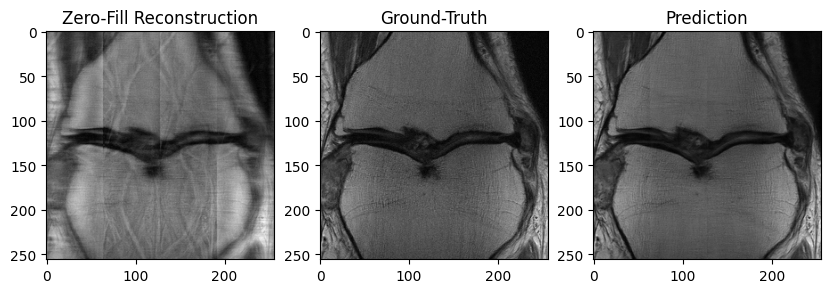

In [39]:
index = 18

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(zero_filling[index], cmap='gray')
plt.title('Zero-Fill Reconstruction')

plt.subplot(1,3,2)
plt.imshow(target[index], cmap='gray')
plt.title('Ground-Truth')

plt.subplot(1,3,3)
plt.imshow(output[index], cmap='gray')
plt.title('Prediction')

print(peak_signal_noise_ratio(target[index], output[index], data_range=target[index].max()))
print(structural_similarity(target[index], output[index], data_range=target[index].max()))

Text(0.5, 1.0, 'Error Maps')

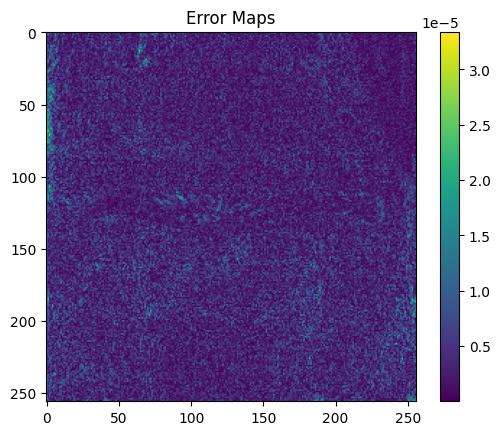

In [40]:
plt.imshow(np.abs(target[index]-output[index]), cmap='viridis')
plt.colorbar()
plt.title('Error Maps')

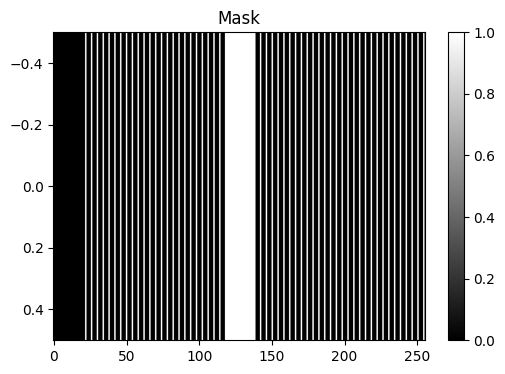

In [41]:
mask_2d = np.squeeze(mask[10])

plt.figure(figsize=(6, 4))
plt.imshow(mask_2d[np.newaxis, :], aspect='auto', cmap='gray')
plt.title('Mask')
plt.colorbar()
plt.show()

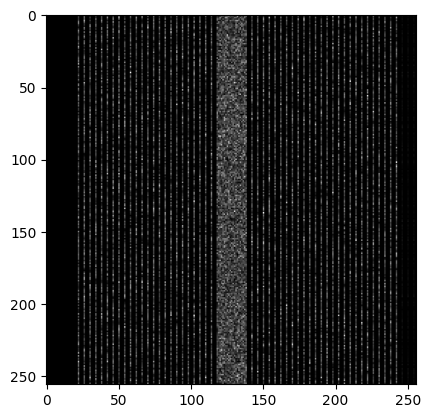

In [88]:
# dd = fastmri.complex_abs(masked_kspace)
# shape = (masked_kspace.shape[0], masked_kspace.shape[1], 20, 20)
# noise = torch.randn(shape) * 1.3802e-06
# dd[:, :, 120:140, 120:140] += noise
# plt.imshow(dd[0, 0], cmap='gray')

In [42]:
# file = h5py.File(train_file[100], 'r')
# kspace = file['kspace'][()]
# target = file['reconstruction_rss'][()]
# kspace = transforms.to_tensor(kspace)

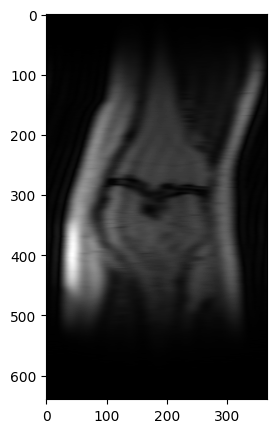

In [68]:
# mask_k = kspace.clone()
# mask_k[:, :, :, :172, :] = 0
# mask_k[:, :, :, 196:, :] = 0

# rec = fastmri.rss(fastmri.complex_abs(fastmri.ifft2c(mask_k)), dim=1)
# plt.figure(figsize=(8, 5))
# plt.imshow(rec[20], cmap='gray')

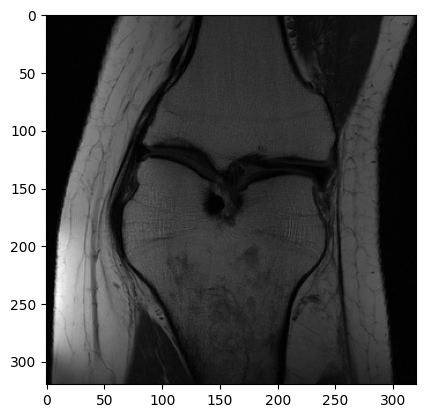

In [44]:
# plt.imshow(target[20], cmap='gray')

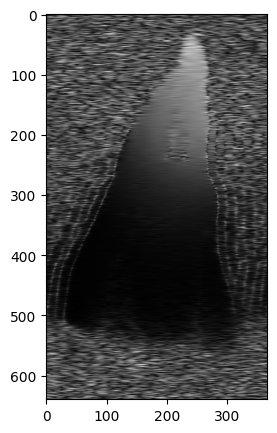

In [71]:
# sen = fastmri.ifft2c(mask_k)
# sen = sen / fastmri.rss_complex(sen, dim=1).unsqueeze(-1).unsqueeze(1)
# sen = fastmri.complex_abs(sen)
# plt.figure(figsize=(8, 5))
# plt.imshow(sen[10, 5, :, :], cmap='gray')

In [61]:
# ss = fastmri.complex_mul(fastmri.ifft2c(mask_k), fastmri.complex_conj(sen)).sum(dim=1, keepdim=True)

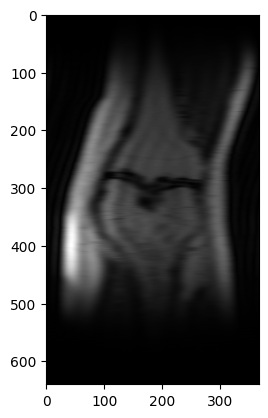

In [67]:
# plt.imshow(ss[20, 0, :, :, 0], cmap='gray')

<h2> Misc. </h2>

In [46]:
# output = self.forward(masked_kspace, mask)
# target, output = transforms.center_crop_to_smallest(target, output)
# val_loss = self.loss(output.unsqueeze(1), target.unsqueeze(1), data_range=max_value)
# target, output = target.detach().cpu().numpy(), output.detach().cpu().numpy()
# PSNR = psnr(target, output)
# SSIM = ssim(target, output)

In [47]:
# data = h5py.File(train_file[100], 'r')
# kspace = data['kspace'][()]
# target = data['reconstruction_rss'][()]
# kspace.shape

In [48]:
# import pandas as pd
# acq = ('CORPDFS_FBK', 'CORPD_FBK')

# fn, acquisition = [], []
# for file in multicoil:
#     with h5py.File(file, 'r') as data:
#         attr = dict(data.attrs)
#         fn.append(file)
#         acquisition.append(attr['acquisition'])
        
# data_frame = pd.DataFrame({'file_name':fn, 'acquisition':acquisition})
# data_frame.to_csv('val_M4Raw.csv', index=False)

In [49]:
# file = h5py.File(train_file[2], 'r')
# target = file['reconstruction_rss'][()]
# kspace = file['kspace'][()]
# kspace.shape

In [50]:
# fig, axes = plt.subplots(3,3, figsize=(12, 8))
# idx = 10
# axes = axes.flatten()
# for i in range(9):
#     axes[i].imshow(target[i+idx], cmap='gray')

# plt.tight_layout()
# plt.show()

In [51]:
# file = h5py.File(train_file[1], 'r')
# kspace = file['kspace'][()]
# target = file['reconstruction_rss'][()]
# kspace.shape, target.shape

In [52]:
# img = fastmri.ifft2c(transforms.to_tensor(kspace))
# img = fastmri.complex_abs(img)
# print(img.shape)

In [53]:
# image = fastmri.complex_abs(img)
# image, target = transforms.center_crop_to_smallest(image, target)
# image.shape, target.shape

In [5]:
# plt.figure(figsize=(10, 10))
# plt.subplot(1,2,1)
# index = 20
# plt.imshow(image[index], cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(target[index], cmap='gray')